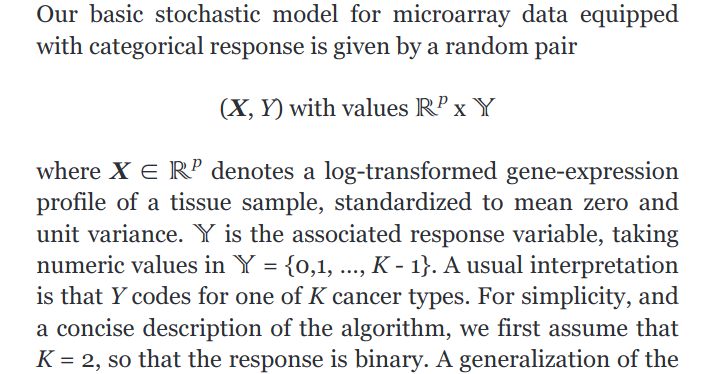

In [111]:
import numpy as np

# X
p, n = 8 , 4
standardize = True
x = np.random.rand(p, n)
print('original matrix:\n {}\n'.format(x))

if standardize:
    means = np.mean(x)
    standard_deviation = np.std(x)
    if np.any(standard_deviation == 0):
        raise ValueError("There are predictor variables with standard deviation = 0")
    x = x - means / standard_deviation
    print('standardized matrix:\n {}\n'.format(x))
else:
    means = None
    standard_deviation = None

original matrix:
 [[0.59907609 0.12521793 0.99369902 0.08424838]
 [0.54562047 0.4949431  0.23709524 0.55525918]
 [0.44785462 0.62712409 0.41595623 0.89517337]
 [0.22231219 0.90620981 0.08897711 0.31569453]
 [0.69848929 0.18055481 0.78656541 0.16748749]
 [0.59886883 0.28767469 0.7257827  0.89585502]
 [0.83206387 0.22026989 0.61000542 0.78616112]
 [0.76202359 0.10959187 0.75148432 0.92216065]]

standardized matrix:
 [[-1.25782995 -1.73168812 -0.86320702 -1.77265767]
 [-1.31128558 -1.36196294 -1.6198108  -1.30164686]
 [-1.40905142 -1.22978195 -1.44094981 -0.96173268]
 [-1.63459385 -0.95069623 -1.76792893 -1.54121152]
 [-1.15841675 -1.67635124 -1.07034064 -1.68941855]
 [-1.25803721 -1.56923136 -1.13112334 -0.96105102]
 [-1.02484217 -1.63663616 -1.24690063 -1.07074493]
 [-1.09488246 -1.74731418 -1.10542173 -0.9347454 ]]



In [112]:
# Y
y = np.random.randint(0, 2, n)

print('response variable:\n {}\n'.format(y))

response variable:
 [0 1 1 1]



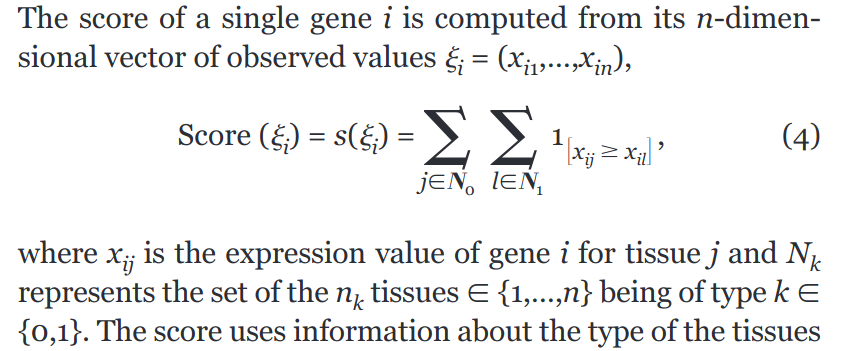

In [113]:
# scores

N0 = [x for x in range(n) if y[x] == 0]
N1 = [x for x in range(n) if y[x] == 1]
print(N0, N1)

scores = np.zeros(p)
for index, row in enumerate(x):
        for j in N1:
            for l in N0:
                if row[j] >= row[l]:
                    scores[index] += 1
       
print(scores)

[0] [1, 2, 3]
[1. 1. 2. 2. 1. 2. 0. 1.]
